# Machine Learning Engineer Nanodegree
## Capstone Project
Simon Jackson
March 21st, 2017

---

In [13]:
import os
import numpy as np
import pandas as pd

# Pretty display for notebooks
%matplotlib inline

## Data Importing and preprocessing

Data was downloaded as .zip format...

Extract all data from zip files into the same directory

In [2]:
# Utility variables
data_directory = "data"

In [3]:
from scripts import extract_zips

# Extract all files from zip folders in data directory,
# into data directory
if False:
    extract_zips.extract_all(data_directory)
else:
    print "Extraction turned off. Check that files have been extracted."
    
print "\nFiles in the data directory:\n"
for f in os.listdir(data_directory):
    print "- " + f

Extraction turned off. Check that files have been extracted.

Files in the data directory:

- genome_scores.csv
- genome_tags.csv
- imdb-5000-movie-dataset.zip
- link.csv
- movie.csv
- movielens-20m-dataset.zip
- movie_metadata.csv
- rating.csv
- tag.csv


### IMDB data

In [4]:
from scripts import data_imdb

imdb = data_imdb.prep(data_directory)

data\movie_metadata.csv read with 5043 rows and 28 columns.


In [5]:
imdb.shape

(5043, 23)

In [6]:
# Column types
imdb.dtypes

color                         object
num_critic_for_reviews       float64
duration                     float64
director_facebook_likes      float64
actor_3_facebook_likes       float64
actor_1_facebook_likes       float64
gross                        float64
genres                        object
movie_title                   object
num_voted_users                int64
cast_total_facebook_likes      int64
facenumber_in_poster         float64
movie_imdb_link               object
num_user_for_reviews         float64
language                      object
country                       object
content_rating                object
budget                       float64
title_year                   float64
actor_2_facebook_likes       float64
imdb_score                   float64
aspect_ratio                 float64
movie_facebook_likes           int64
dtype: object

In [7]:
# Examine few rows
imdb.head(n = 5)

,color,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,genres,movie_title,num_voted_users,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,723.0,178.0,0.0,855.0,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,Avatar,886204,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,302.0,169.0,563.0,1000.0,40000.0,309404152.0,Action|Adventure|Fantasy,Pirates of the Caribbean: At World's End,471220,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,602.0,148.0,0.0,161.0,11000.0,200074175.0,Action|Adventure|Thriller,Spectre,275868,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,813.0,164.0,22000.0,23000.0,27000.0,448130642.0,Action|Thriller,The Dark Knight Rises,1144337,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,NaN,NaN,131.0,NaN,131.0,NaN,Documentary,Star Wars: Episode VII - The Force Awakens ...,8,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


This information will be used for content-based filtering of movies.

In [8]:
# Separate title and IMDB link
#imdb_titles = imdb[['movie_title', 'movie_imdb_link']]

#imdb.drop(['director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name',
#           'plot_keywords', 'movie_title', 'movie_imdb_link'], axis = 1, inplace = True)

#print 'Titles data has {} rows and {} columns'.format(*imdb_titles.shape) 
#print 'Movie data has {} rows and {} columns'.format(*imdb.shape)

#### Categorical variables

- `language`: convert to 1 = English, 0 = other
- `genres`: will need to be split into multiple variables indicating whether certain genres were tagged.
- `country`: 1 = USA, 0 = Other (possibly a separate one for UK?)
- `content_rating`: will need a number of categories (R, PG, PG-13, G, etc)

In [9]:
imdb['language'].value_counts()
#imdb['content_rating']#.nunique

English       4704
French          73
Spanish         40
Hindi           28
Mandarin        26
German          19
Japanese        18
Cantonese       11
Russian         11
Italian         11
Korean           8
Portuguese       8
Arabic           5
Swedish          5
Hebrew           5
Danish           5
Persian          4
Dutch            4
Polish           4
Norwegian        4
Thai             3
Chinese          3
None             2
Zulu             2
Aboriginal       2
Icelandic        2
Romanian         2
Dari             2
Indonesian       2
Urdu             1
Czech            1
Filipino         1
Tamil            1
Slovenian        1
Swahili          1
Aramaic          1
Greek            1
Hungarian        1
Bosnian          1
Kazakh           1
Panjabi          1
Kannada          1
Mongolian        1
Dzongkha         1
Vietnamese       1
Maya             1
Telugu           1
Name: language, dtype: int64

In [10]:
imdb.ix[imdb.language != 'English', 'language'] = 'Other'
imdb.language.value_counts()

English    4704
Other       339
Name: language, dtype: int64

In [11]:
# Obtain dummy coded versions of all genres
dummy_genres = imdb.genres.str.lower().str.get_dummies(sep='|')
imdb = pd.concat([imdb, dummy_genres ], axis=1, join='inner')
imdb.head(5)

,color,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,genres,movie_title,num_voted_users,...,mystery,news,reality-tv,romance,sci-fi,short,sport,thriller,war,western
0,Color,723.0,178.0,0.0,855.0,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,Avatar,886204,...,0,0,0,0,1,0,0,0,0,0
1,Color,302.0,169.0,563.0,1000.0,40000.0,309404152.0,Action|Adventure|Fantasy,Pirates of the Caribbean: At World's End,471220,...,0,0,0,0,0,0,0,0,0,0
2,Color,602.0,148.0,0.0,161.0,11000.0,200074175.0,Action|Adventure|Thriller,Spectre,275868,...,0,0,0,0,0,0,0,1,0,0
3,Color,813.0,164.0,22000.0,23000.0,27000.0,448130642.0,Action|Thriller,The Dark Knight Rises,1144337,...,0,0,0,0,0,0,0,1,0,0
4,NaN,NaN,NaN,131.0,NaN,131.0,NaN,Documentary,Star Wars: Episode VII - The Force Awakens ...,8,...,0,0,0,0,0,0,0,0,0,0


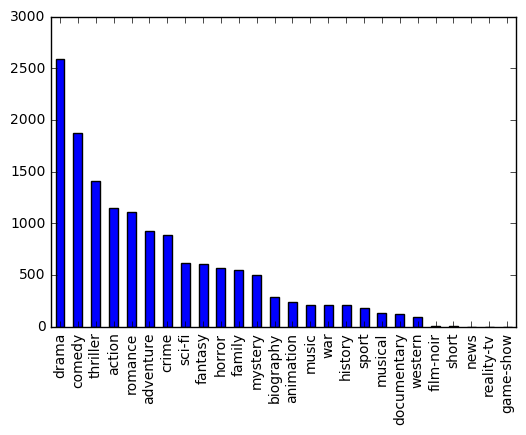

In [14]:
# Show counts of different genres
x = pd.melt(dummy_genres)
x.variable[x.value == 1].value_counts().plot(kind="bar")